# Project：Try changing the vocabulary size

&nbsp;

&nbsp;

## 1. 라이브러리／데이터 준비


사용할 데이터는 로이터 뉴스 데이터이다.

이 데이터는 총 46개의 클래스로 구성되며, 해당 뉴스가 어느 카테고리에 속하는지를 예측하기 위한 데이터이다.

텐서플로우 데이터셋에서 제공하고 있는 데이터로 쉽게 다운로드가 가능하다.

In [1]:
## 라이브러리
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf


print(tf.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)


## 로이터 뉴스 데이터
from tensorflow.keras.datasets import reuters


## 벡터화
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


## 머신러닝 모델
from sklearn.naive_bayes import MultinomialNB    ##다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score ## 정확도 계산


## F1-Score, Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


print("✔️")

2.6.0
3.4.3
0.11.2
1.21.4
1.3.3
1.0
✔️


&nbsp;

### 훈련 데이터와 테스트 데이터 로드하기

---

텐서플로우 데이터셋으로부터 로이터 뉴스 데이터를 받아오는 함수를 만들도록 하겠다.

In [2]:
def load_reuters(num_words=None, test_split=0.25):
    
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=test_split)
    
    return x_train, y_train, x_test, y_test


load_reuters 함수에서는 2개의 매개변수를 사용할 수 있다.

- num_words：이 데이터에서 빈도수 기준으로 상위 몇 번째 단어까지 사용할 것인지 조정.<br>
각단어는 고유한 번호가 정해져 있는 상태이고, 이를 통해서 사용할 단어의 수를 정함.


- test_split：전체 데이터중에서 몇 ％를 테스트 데이터로 사용할지의 의미.<br>
예> test_split=0.2 → 전체데이터에서 80％를 훈련데이터로, 20％를 테스트데이터로 사용.

In [3]:
sample_x_train, sample_y_train, sample_x_test, sample_y_test = load_reuters(num_words=10000, test_split=0.2)

In [4]:
print('훈련 샘플의 수: {}'.format(len(sample_x_train)))
print('테스트 샘플의 수: {}'.format(len(sample_x_test)))

num_classes = max(sample_y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246
클래스의 수 : 46


&nbsp;

### 데이터 분포 확인하기

<hr>



훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


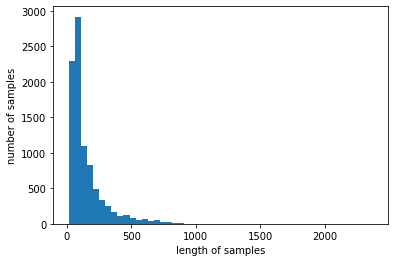

In [5]:
print("훈련용 뉴스의 최대 길이 :{}".format(max(len(l) for l in sample_x_train)))
print("훈련용 뉴스의 평균 길이 :{}".format(sum(map(len, sample_x_train))/len(sample_x_train)))

plt.hist([len(s) for s in sample_x_train], bins=50)
plt.xlabel("length of samples")
plt.ylabel("number of samples")
plt.show()

길이가 가장 긴 뉴스의 길이는 2,376 이고, 평균 길이는 145 임을 확인 할 수 있다.

클래스의 분포를 확인해보자.

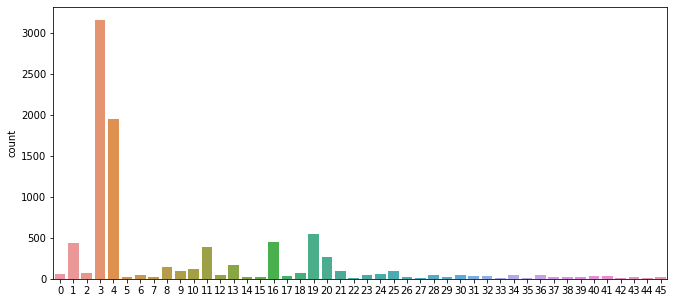

In [6]:
fig, axe = plt.subplots(ncols = 1)
fig.set_size_inches(11,5)
sns.countplot(x = sample_y_train)
plt.show()

대부분의 뉴스 데이터는 3번, 4번 클래스가 차지하고 있다.

수치적으로 정확히 몇 개인지 출력해보자.

In [7]:
unique_elements, counts_elements = np.unique(sample_y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


3번 클래스가 3159개, 4번 클래스가 1949개 임을 확인할 수가 있다.

&nbsp;

### 본 뉴스 데이터로 복원해보기

---



로이터 뉴스 데이터는 '단어'를 key값으로, 고유한 '정수'를 value로 가지는 dictionary를 제공한다.

그것을 단어장(Vocabulary)이라고 할 수 있는데, 먼저 이를 `word_index`로 저장해보면 아래와 같다.

In [8]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

이제 `word_index` 에 단어를 입력하면 이 단어가 어떤 정수와 맵핑이 되는지를 알 수 있다.

하지만, 본 뉴스 데이터로 되돌리는 과정에는 `word_index`보다는 정수로부터 단어를 얻을 수 있는 `index_word`가 필요하다.

**로이터 뉴스 데이터에는 word_index에 입력으로 했을 때, 얻는 숫자보다는 +3 을 한 숫자가 원래 고유한 숫자이다.**

**`reuters.get_word_index`에는 실제 단어에 맵핑 한 정수에 -3 을 한 정수를 입력해 놓았기 때문이다.**

그렇기 때문에 `word_index`에서 `index_word`를 만들 때, 각 정수에 **+3**을 해주어야 한다.

In [9]:
index_to_word = { index+3 : word for word, index in word_index.items() }

또한, 여기서 0, 1, 2 번째 값은 사실 각각 `<pad>`, `<sos>`, `<unk>`라는 자연어 처리를 위한 특별한 토큰들을 위해 맵핑된 번호이다.

그래서 만들어진 `index_to_word`에 추가적으로 아래의 작업을 해주어야 진짜 `index_to_word`가 완성된다.

In [10]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index] = token

`index_to_word`를 통해서 훈련용 뉴스 기사를 원래 텍스트로 복원하려면 다음과 같이 사용한다.

In [11]:
def seq2text(index_to_word, input_seq):
    print(" ".join([index_to_word[index] for index in input_seq]))

In [12]:
seq2text(index_to_word, sample_x_train[0])

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


노드 학습 부분에서 사용한 시퀀스의 경우 원래 텍스트로 복원할 경우 결과는 다음과 같다.

In [13]:
seq2text(index_to_word, [4, 587, 23, 133, 6, 30, 515])

the transaction is expected to be completed


&nbsp;

전체 훈련용 뉴스 데이터와 전체 테스트용 뉴스 데이터를 텍스트 데이터로 변환하는 함수를 만들겠다.

In [14]:
def seq2texts(index_to_word, input_sequences):
    decoded = []
    for i in range(len(input_sequences)):
        t = " ".join([index_to_word[index] for index in input_sequences[i]])
        decoded.append(t)
    return decoded

In [15]:
sample_x_train_decoded = seq2texts(index_to_word, sample_x_train)
sample_x_train_decoded[:2]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3']

In [16]:
sample_x_test_decoded = seq2texts(index_to_word, sample_x_test)
sample_x_test_decoded[:2]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> yulo said yulo told reuters a survey during the curren

&nbsp;

## 2. 벡터화

딥러닝이 아닌 머신러닝 방법을 사용하여 텍스트 분류를 진행 할 것이기 때문에 벡터화 방법도 인공 신경망이 아닌 방법을 사용한다.

여기에서 사용할 벡터화 방법은 Bag of Words 가설을 기반으로 하는 **DTM, TF-IDF** 행렬이다.



Document Term Matrix, DTM은 사이킷런의 `CountVectorizer()`를 통해서 생성할 수 있다.



DTM을 생성하고, DTM의 크기를 확인해보자.



In [17]:
dtmvector = CountVectorizer()
sample_x_train_dtm = dtmvector.fit_transform(sample_x_train_decoded)
print(sample_x_train_dtm.shape)

(8982, 9670)


훈련용 뉴스의 수가 총 8,982개였기 때문에 DTM의 행의 개수는 8,982개임을 확인할 수 있다.

그런데 이상한 점은 DTM 열의 개수는 이보다 적은 9,670개밖에 되지 않는데, 

그 이유는 DTM이 자체적인 규칙에 따라서 불필요하다고 판단하는 토큰들을 제거하기 때문이다.



TF-IDF Matrix는 사이킷런의 `TfidfTransformer()`를 통해서 생성할 수 있다.

TF-IDF Matrix는 추가적인 전처리를 하지 않는 이상, DTM과 동일한 크기를 가진다.

In [18]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(sample_x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


&nbsp;

이 프로젝트에서 사용할 벡터화 방법은 Bag of Words 가설을 기반으로 하는 **DTM, TF-IDF** 행렬이다.

이를 위해, 이전에 정의한 load_reuters 함수를 조금 변경하도록 하겠다.

매개변수는 그대로 사용하고, 추가된 내용들은 아래와 같다.

1. index_to_word 작성 및 반환.


2. 텍스트 데이터의 벡터화 및 반환

In [19]:
def load_reuters(num_words=None, test_split=0.25):
    
    (x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=num_words, test_split=test_split)
    
    
    ## ① 시퀀스 데이터를 텍스트 데이터로 변환
    ## 단어장(Vocabulary)
    word_index = reuters.get_word_index(path="reuters_word_index.json")
    ## 정수로부터 단어를 얻을 수 있는 `index_word`
    index_to_word = { index+3 : word for word, index in word_index.items() }
    ## index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣는다.
    for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
        index_to_word[index]=token
    ## 텍스트 데이터 저장공간
    decoded = []
    ## Sequences to Sentences
    for i in range(len(x_train)):    ## train
        t = ' '.join([index_to_word[index] for index in x_train[i]])
        decoded.append(t)
    x_train_decoded = decoded
    decoded = []
    for i in range(len(x_test)):    ## test
        t = ' '.join([index_to_word[index] for index in x_test[i]])
        decoded.append(t)
    x_test_decoded = decoded
    
    
    ## ② 벡터화
    ## Vectorizer - DTM
    dtmvector = CountVectorizer()
    x_train_dtm = dtmvector.fit_transform(x_train_decoded)    ## train
    x_test_dtm =dtmvector.transform(x_test_decoded)       ## test
    ## Vectorizer - TF-IDF
    tfidf_transformer = TfidfTransformer()
    tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)    ## train
    tfidfv_test = tfidf_transformer.transform(x_test_dtm)      ## test
    
    
    return x_train, y_train, x_test, y_test, tfidfv_train, tfidfv_test, index_to_word

&nbsp;

## 3. 평가

&nbsp;

### Precision, Recall & F1 Score

---

본 프로젝트에서는 성능 비교를 위한 척도로 **정확도(Accuracy)** 를 사용한다.

**정확도(Accuracy)**는 가장 직관적으로 모델의 성능을 나타낼 수 있는 평가 지표이다.

하지만 label 불균형인 경우를 제대로 고려하지 못하기 때문에, 이러한 경우에는 f1-score를 사용하기도 한다.

&nbsp;

최종 결과에서 각각이 의미하는 바는 다음과 같다.

- `macro`：단순평균


- `weighted`：각 클래스에 속하는 표본의 개수로 가중평균


- `accuracy`：정확도. 전체 학습 데이터의 개수에서 클래스를 정확하게 맞춘 개수의 비율



### Confusion Matrix

----

Confusion Matrix는 생소한 개념이라기보다는 앞서 f1-score를 이해하기 위해 읽었던 위의 글의 가장 처음에 있던 행렬이다.

<table>
    <tr>
        <td></td>
        <td></td>
        <td colspan=2>Predicted</td>
    </tr>
    <tr>
        <td></td>
        <td></td>
        <td>Positive</td>
        <td>Negative</td>
    </tr>
    <tr>
        <td rowspan=2>Actual</td>
        <td>Positive</td>
        <td>TP</td>
        <td>FN</td>
    </tr>
    <tr>
        <td>Negative</td>
        <td>FP</td>
        <td>TN</td>
    </tr>
</table>


- TP : True로 예측하고 실제 값도 True
- TN : False로 예측하고 실제 값도 False
- FP : True로 예측하고 실제는 False
- FN : False로 예측하고 실제는 True

&nbsp;

**Accuarcy**

- 전체 중 맞게 맞게 예측한 비율

$$ TP+FN \over TP+TN+FP+FN $$


**Precision**

- Positive에 속하는 것들 중 실제 Positvie 인것.

$$ TP \over TP+FP $$


**Recall (sensitivty)**

- 실제로 Positive인 것들 중 Positive로 예측한 비율

$$ TP \over TP + FN $$


**Specificity**

- Negative에 속하는 것들 중 실제 Negative 인것.

$$ TP + TN \over TP + TN + FP + FN $$


**F1 Measure**

- 위의 Precision과 Recall을 이용.

$$ 2 \times Recall \times Precision \over Recall + Precision $$


&nbsp;

&nbsp;

## 4. 다양한 머신러닝 모델 사용하기

사이킷런이 제공하는 머신러닝 모델들은 공통적으로 `fit()`이라는 함수를 제공하고 있다. 

훈련 데이터와 해당 훈련 데이터에 대한 레이블을 인자로 사용하면 모델이 이를 학습한다.



여기서는 8개의 모델을 통해 학습을 하고 그 결과를 딕셔너리에 저장하는 함수를 만들어 사용하도록 하겠다.

In [20]:
num_words_list = [6000, 12000, None]

In [21]:
## 훈련결과 저장 변수
# ret_modelname = []
# ret_numwords = []
# ret_accuracy = []
# ret_f1score = []

## 모델
mnb_model = MultinomialNB()
cnm_model = ComplementNB()
lr_model = LogisticRegression(C=10000, penalty="l2", max_iter=3000)
lsvc_model = LinearSVC(C=1000, penalty="l1", max_iter=3000, dual=False)
dt_model = DecisionTreeClassifier(max_depth=10, random_state=0)
rf_model = RandomForestClassifier(n_estimators=5, random_state=0)
gb_model = GradientBoostingClassifier(random_state=0)
voting_model = VotingClassifier(estimators=[
    ("lr", LogisticRegression(C=10000, max_iter=3000, penalty="l2")),
    ("cb", ComplementNB()),
    ("grbt", GradientBoostingClassifier(random_state=0))], voting="soft")

models = [mnb_model, cnm_model, lr_model, lsvc_model, dt_model, rf_model, gb_model, voting_model]    

In [22]:
def ml_model_fit(num_words_list, models):
    
    ## 훈련 리포트 저장할 변수
    df_report = pd.DataFrame(columns=["Model", "num_words", "Accuracy", "F1-Score"])

    ## 지정 num_words 에 따라, 데이터 불러오기
    for num_words in num_words_list:
            
        x_train, y_train, x_test, y_test, tfidfv_train, tfidfv_test, index_to_word = load_reuters(num_words)
            
        ## 모델 하나씩 훈련 및 평가
        for model in models:

            ## fit
            model.fit(tfidfv_train, y_train)

            ## Predict & Report
            report = classification_report(y_test, model.predict(tfidfv_test), zero_division=0, output_dict=True)

            ## Report
            model_name = model.__class__.__name__
            accuracy = report["accuracy"]
            f1_score = report["weighted avg"]["f1-score"]
            df_row = pd.DataFrame(
                {"Model":[model_name], 
                 "num_words":[str(num_words)], 
                 "Accuracy":[round(accuracy, 3)], 
                 "F1-Score":[round(f1_score, 3)]}
            )
            print(df_row)
            df_report = df_report.append(df_row, ignore_index=True)
            
    return df_report


In [23]:
## 테스트
## ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ
# num_words_list = [6000, None]
# models = [mnb_model]

ml_model_fit(num_words_list, models)

           Model num_words  Accuracy  F1-Score
0  MultinomialNB      6000     0.671     0.595
          Model num_words  Accuracy  F1-Score
0  ComplementNB      6000     0.774     0.751
                Model num_words  Accuracy  F1-Score
0  LogisticRegression      6000     0.807     0.802


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


       Model num_words  Accuracy  F1-Score
0  LinearSVC      6000     0.779     0.775
                    Model num_words  Accuracy  F1-Score
0  DecisionTreeClassifier      6000     0.615     0.605
                    Model num_words  Accuracy  F1-Score
0  RandomForestClassifier      6000     0.689     0.664
                        Model num_words  Accuracy  F1-Score
0  GradientBoostingClassifier      6000     0.767     0.764
              Model num_words  Accuracy  F1-Score
0  VotingClassifier      6000     0.815      0.81
           Model num_words  Accuracy  F1-Score
0  MultinomialNB     12000     0.644     0.562
          Model num_words  Accuracy  F1-Score
0  ComplementNB     12000     0.778     0.754
                Model num_words  Accuracy  F1-Score
0  LogisticRegression     12000     0.813     0.807


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


       Model num_words  Accuracy  F1-Score
0  LinearSVC     12000     0.789     0.786
                    Model num_words  Accuracy  F1-Score
0  DecisionTreeClassifier     12000     0.609     0.545
                    Model num_words  Accuracy  F1-Score
0  RandomForestClassifier     12000     0.667     0.639
                        Model num_words  Accuracy  F1-Score
0  GradientBoostingClassifier     12000     0.767     0.764
              Model num_words  Accuracy  F1-Score
0  VotingClassifier     12000     0.818     0.814
           Model num_words  Accuracy  F1-Score
0  MultinomialNB      None     0.597       0.5
          Model num_words  Accuracy  F1-Score
0  ComplementNB      None     0.771     0.742
                Model num_words  Accuracy  F1-Score
0  LogisticRegression      None     0.815      0.81


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


       Model num_words  Accuracy  F1-Score
0  LinearSVC      None     0.788     0.784
                    Model num_words  Accuracy  F1-Score
0  DecisionTreeClassifier      None     0.622     0.576
                    Model num_words  Accuracy  F1-Score
0  RandomForestClassifier      None     0.663     0.634
                        Model num_words  Accuracy  F1-Score
0  GradientBoostingClassifier      None     0.772     0.768
              Model num_words  Accuracy  F1-Score
0  VotingClassifier      None     0.822     0.818


,Model,num_words,Accuracy,F1-Score
0,MultinomialNB,6000,0.671,0.595
1,ComplementNB,6000,0.774,0.751
2,LogisticRegression,6000,0.807,0.802
3,LinearSVC,6000,0.779,0.775
4,DecisionTreeClassifier,6000,0.615,0.605
5,RandomForestClassifier,6000,0.689,0.664
6,GradientBoostingClassifier,6000,0.767,0.764
7,VotingClassifier,6000,0.815,0.810
8,MultinomialNB,12000,0.644,0.562
9,ComplementNB,12000,0.778,0.754


데이터를 정리하면 아래와 같다.

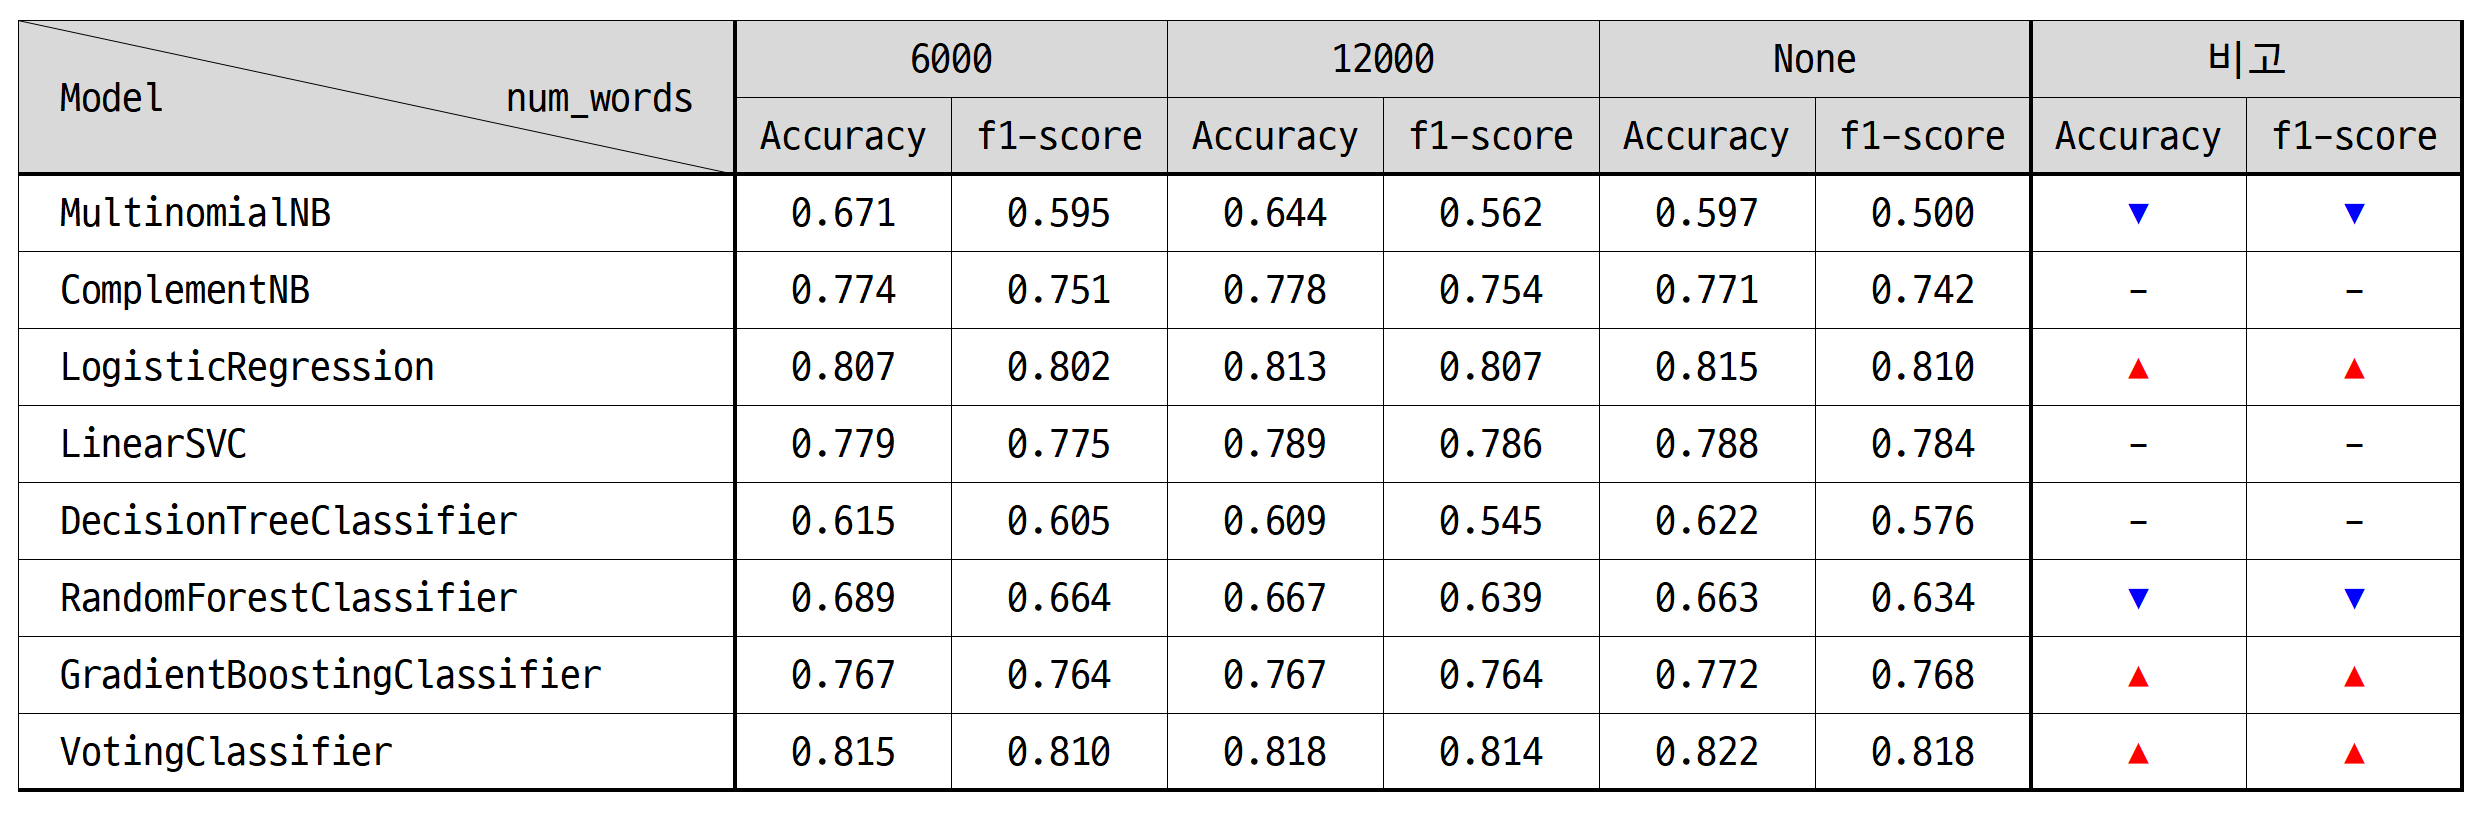

시간이 오래 걸리는 모델일 수록 전반적으로 높은 수치를 보여주었다.

성능이 괜찮은 모델들을 고려해 본다면, 대략 0.75~0.80 내외의 수치라고 볼 수 있겠다.

&nbsp;

## 5. 딥러닝 모델과 비교해보기

&nbsp;

### LSTM

----

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score
from keras import backend as K

In [25]:
embedding_dim = 128
hidden_units = 128
vocab_size=12000
num_classes = 46
max_len = 256

f1-score 산출을 위해 함수를 따로 정의해 주었다.

모델 컴파일 단계에서 metrics 에 추가를 해 주는 방법으로 사용한다.

In [26]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [27]:
## 뉴스기사 데이터 불러오기
## 동일한 전처리 조건을 위해 초기값 그대로 사용하도록 하겠다.
x_train, y_train, x_test, y_test, tfidfv_train, tfidfv_test, index_to_word = load_reuters(num_words=vocab_size)

하이퍼파라미터인 임베딩 벡터의 차원은 128, 은닉 상태의 크기는 128 이다. 

단어 집합의 크기는 앞서 None 으로 전체를 사용할 것이다.

모델은 다 대 일 구조의 LSTM을 사용한다.

해당 모델은 마지막 시점에서 46개의 선택지 중 하나의 선택지를 예측하는 다중 클래스 분류 문제를 수행하는 모델이다.

다중 클래스 분류 문제의 경우, 출력층에 소프트맥스 회귀를 사용해야 하므로 활성화 함수로는 소프트맥스 함수를 사용하고,

손실 함수로 크로스 엔트로피 함수를 사용한다. 하이퍼파라미터인 배치 크기는 128이며, 30 에포크를 수행한다.

In [28]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8421,)
(8421,)
(2807,)
(2807,)


In [29]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [30]:
lstm_model = Sequential()
lstm_model.add(Embedding(vocab_size, embedding_dim))
lstm_model.add(LSTM(hidden_units))
lstm_model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

lstm_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['acc', f1_score])


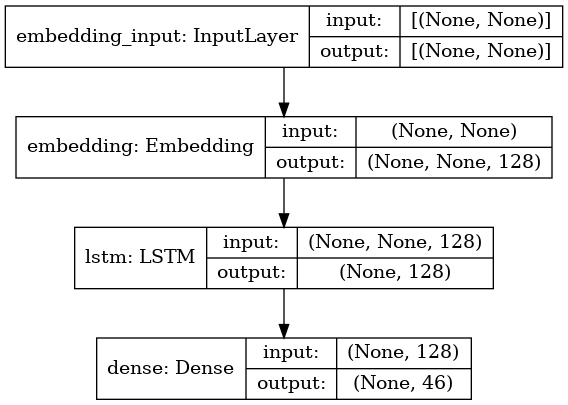

In [31]:
tf.keras.utils.plot_model(lstm_model, show_shapes=True)

In [32]:
# history = model.fit(X_train, y_train, batch_size=128, epochs=30, callbacks=[es, mc], validation_data=(X_test, y_test))
lstm_history = lstm_model.fit(
    x_train, y_train, 
    batch_size=128, epochs=30, 
    callbacks=[es], validation_data=(x_test, y_test))


Epoch 1/30
66/66 [==============================] - 5s 28ms/step - loss: 2.6482 - acc: 0.3384 - f1_score: 0.0134 - val_loss: 2.4108 - val_acc: 0.3541 - val_f1_score: 0.0000e+00
Epoch 2/30
66/66 [==============================] - 1s 20ms/step - loss: 2.1211 - acc: 0.4546 - f1_score: 0.3297 - val_loss: 1.8670 - val_acc: 0.4977 - val_f1_score: 0.5605
Epoch 3/30
66/66 [==============================] - 1s 20ms/step - loss: 1.7623 - acc: 0.5344 - f1_score: 0.5939 - val_loss: 1.9450 - val_acc: 0.4011 - val_f1_score: 0.4475
Epoch 4/30
66/66 [==============================] - 1s 20ms/step - loss: 1.7400 - acc: 0.5377 - f1_score: 0.6046 - val_loss: 1.7988 - val_acc: 0.5169 - val_f1_score: 0.5628
Epoch 5/30
66/66 [==============================] - 1s 22ms/step - loss: 1.5514 - acc: 0.5976 - f1_score: 0.6461 - val_loss: 1.6194 - val_acc: 0.6099 - val_f1_score: 0.6415
Epoch 6/30
66/66 [==============================] - 1s 20ms/step - loss: 1.4129 - acc: 0.6282 - f1_score: 0.6737 - val_loss: 1.6558

In [33]:
lstm_result = lstm_model.evaluate(x_test, y_test, verbose=1)

for name, value in zip(lstm_model.metrics_names, lstm_result):
    print("%s: %.3f" % (name, value))

88/88 [==============================] - 1s 6ms/step - loss: 1.5885 - acc: 0.6651 - f1_score: 0.6924
loss: 1.589
acc: 0.665
f1_score: 0.692


&nbsp;

### BiLSTM with Attention Mechanism

----

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [35]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V = Dense(1)

    def call(self, values, query): # 단, key와 value는 같음
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

입력층과 임베딩층을 설계한다.

In [36]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

단어들을 128차원의 벡터로 임베딩하도록 설계하였다.

여기서는 양방향 LSTM을 두 층을 사용하여 설계한다. 

우선, 첫번째 층은 두번째 층을 위에 쌓을 예정이므로 return_sequences를 True로 지정한다.

In [37]:
bi_lstm_model = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

두번째 층은 상태를 리턴받아야 하므로 return_state를 True로 지정한다.

In [38]:
bi_lstm_model, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(bi_lstm_model)

In [39]:
print(bi_lstm_model.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 256, 128) (None, 64) (None, 64) (None, 64) (None, 64)


순방향 LSTM의 은닉 상태와 셀상태를 forward_h, forward_c에 저장하고, 

역방향 LSTM의 은닉 상태와 셀 상태를 backward_h, backward_c에 저장한다.

각 은닉 상태나 셀 상태의 경우에는 128차원을 가지는데, lstm의 경우에는 (256 × 128)의 크기를 가진다.

foward 방향과 backward 방향이 연결된 hidden state벡터가 모든 시점에 대해서 존재함을 의미한다.

양방향 LSTM을 사용할 경우에는 순방향 LSTM과 역방향 LSTM 각각 은닉 상태와 셀 상태를 가지므로, 

양방향 LSTM의 은닉 상태와 셀 상태를 사용하려면 두 방향의 LSTM의 상태들을 연결(concatenate)해준다.

In [40]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

어텐션 메커니즘에서는 은닉 상태를 사용한다. 이를 입력으로 컨텍스트 벡터(context vector)를 얻는다.



In [41]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(bi_lstm_model, state_h)

컨텍스트 벡터를 밀집층(dense layer)에 통과시키고, 

활성화 함수로는 softmax 함수를 사용한다.


In [42]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(46, activation="softmax")(dropout)
bi_lstm_att_model = Model(inputs=sequence_input, outputs=output)

손실 함수는 categorical_crossentropy를, 옵티마이저로 아담 옵티마이저 사용하고, 모델을 컴파일한다.

In [43]:
bi_lstm_att_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy', f1_score])

모델을 훈련시킨다.



In [44]:
bi_lstm_history = bi_lstm_att_model.fit(
    x_train, y_train, epochs = 20, batch_size = 256, 
    callbacks=[es], validation_data=(x_test, y_test), verbose=1)

Epoch 1/20
33/33 [==============================] - 94s 2s/step - loss: 3.4788 - accuracy: 0.2298 - f1_score: 0.0329 - val_loss: 2.4618 - val_accuracy: 0.4995 - val_f1_score: 0.0106
Epoch 2/20
33/33 [==============================] - 77s 2s/step - loss: 2.4432 - accuracy: 0.4565 - f1_score: 0.3682 - val_loss: 1.8790 - val_accuracy: 0.5490 - val_f1_score: 0.6288
Epoch 3/20
33/33 [==============================] - 77s 2s/step - loss: 2.0437 - accuracy: 0.5232 - f1_score: 0.5674 - val_loss: 1.8159 - val_accuracy: 0.5625 - val_f1_score: 0.6508
Epoch 4/20
33/33 [==============================] - 77s 2s/step - loss: 1.8699 - accuracy: 0.5523 - f1_score: 0.6140 - val_loss: 1.7244 - val_accuracy: 0.5825 - val_f1_score: 0.6551
Epoch 5/20
33/33 [==============================] - 77s 2s/step - loss: 1.7841 - accuracy: 0.5698 - f1_score: 0.6244 - val_loss: 1.6861 - val_accuracy: 0.5921 - val_f1_score: 0.6440
Epoch 6/20
33/33 [==============================] - 77s 2s/step - loss: 1.6869 - accuracy:

In [45]:
bi_lstm_att_result = bi_lstm_att_model.evaluate(x_test, y_test, verbose=1)

for name, value in zip(bi_lstm_att_model.metrics_names, bi_lstm_att_result):
    print("%s: %.3f" % (name, value))

88/88 [==============================] - 19s 219ms/step - loss: 1.6810 - accuracy: 0.6544 - f1_score: 0.6895
loss: 1.681
accuracy: 0.654
f1_score: 0.690


&nbsp;

### Transformer

----

In [46]:
from tensorflow import keras
from tensorflow.keras import layers

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [47]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [48]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=max_len)

In [49]:
embed_dim = 32  # 각 토큰에 대한 임베딩 크기（Embedding size for each token）
num_heads = 2  # 어텐션 헤드의 수（Number of attention heads）
ff_dim = 32  # 트랜스포머 내부 Feed forward network 의 Hidden layer size（Hidden layer size in feed forward network inside transformer）

inputs = layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embed_dim)
x = embedding_layer(inputs)

transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)

x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)

outputs = layers.Dense(46, activation="softmax")(x)


tform_model = keras.Model(inputs=inputs, outputs=outputs)

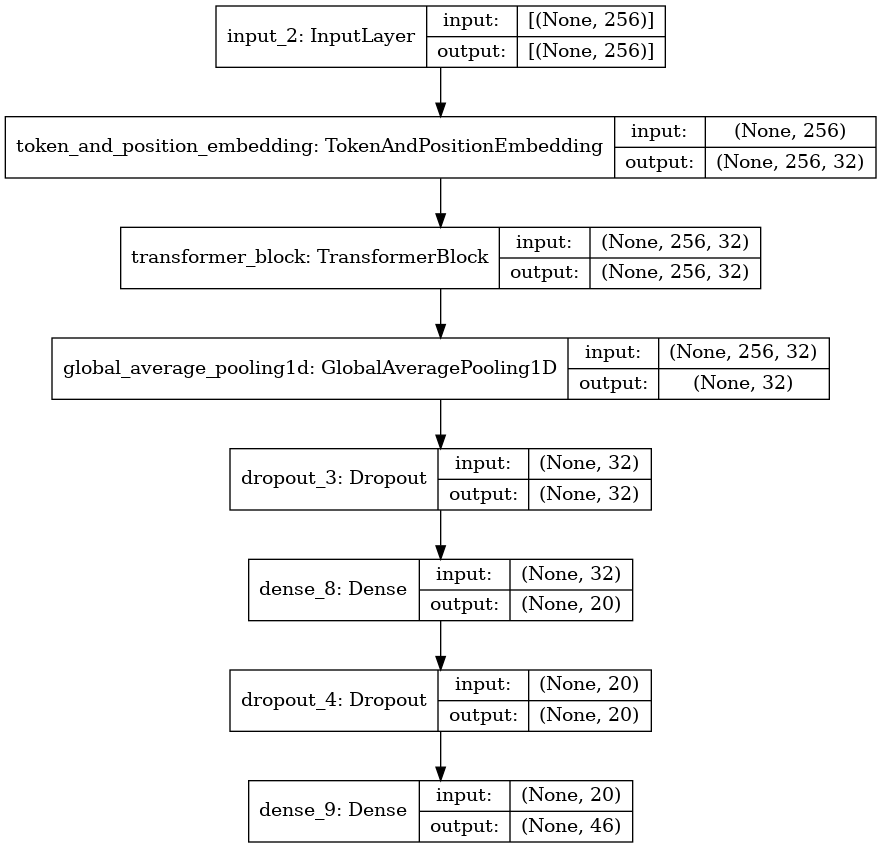

In [50]:
tf.keras.utils.plot_model(tform_model, show_shapes=True)

In [51]:
tform_model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics=["accuracy", f1_score]
)
history = tform_model.fit(
    x_train, y_train, 
    batch_size=128, epochs=20, 
    callbacks=[es], validation_data=(x_test, y_test)
)

Epoch 1/20
66/66 [==============================] - 3s 24ms/step - loss: 2.6249 - accuracy: 0.3496 - f1_score: 0.1473 - val_loss: 2.1786 - val_accuracy: 0.4442 - val_f1_score: 0.4157
Epoch 2/20
66/66 [==============================] - 1s 20ms/step - loss: 2.0020 - accuracy: 0.5083 - f1_score: 0.4690 - val_loss: 1.6991 - val_accuracy: 0.6042 - val_f1_score: 0.6252
Epoch 3/20
66/66 [==============================] - 1s 20ms/step - loss: 1.5615 - accuracy: 0.6249 - f1_score: 0.6466 - val_loss: 1.4610 - val_accuracy: 0.6470 - val_f1_score: 0.6764
Epoch 4/20
66/66 [==============================] - 1s 20ms/step - loss: 1.3083 - accuracy: 0.6853 - f1_score: 0.7052 - val_loss: 1.3309 - val_accuracy: 0.6747 - val_f1_score: 0.7110
Epoch 5/20
66/66 [==============================] - 1s 20ms/step - loss: 1.1242 - accuracy: 0.7254 - f1_score: 0.7493 - val_loss: 1.2705 - val_accuracy: 0.6829 - val_f1_score: 0.7283
Epoch 6/20
66/66 [==============================] - 1s 20ms/step - loss: 0.9460 - acc

In [52]:
results = tform_model.evaluate(x_test, y_test, verbose=2)

for name, value in zip(tform_model.metrics_names, results):
    print("%s: %.3f" % (name, value))

88/88 - 0s - loss: 1.2502 - accuracy: 0.7567 - f1_score: 0.7685
loss: 1.250
accuracy: 0.757
f1_score: 0.768


&nbsp;

vocab_size 를 변경（12000 → None）하여 훈련과 평가를 해보자.

In [53]:
vocab_size=None
x_train, y_train, x_test, y_test, tfidfv_train, tfidfv_test, index_to_word = load_reuters(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [54]:
lstm_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['acc', f1_score])

lstm_history = lstm_model.fit(
    x_train, y_train, 
    batch_size=128, epochs=30, 
    callbacks=[es], validation_data=(x_test, y_test))

lstm_result = lstm_model.evaluate(x_test, y_test, verbose=1)

for name, value in zip(lstm_model.metrics_names, lstm_result):
    print("%s: %.3f" % (name, value))

Epoch 1/30
66/66 [==============================] - 3s 27ms/step - loss: 0.4320 - acc: 0.8940 - f1_score: 0.8890 - val_loss: 1.6169 - val_acc: 0.6569 - val_f1_score: 0.6865
Epoch 2/30
66/66 [==============================] - 1s 20ms/step - loss: 0.3654 - acc: 0.9090 - f1_score: 0.9047 - val_loss: 1.6382 - val_acc: 0.6812 - val_f1_score: 0.7028
Epoch 3/30
66/66 [==============================] - 1s 20ms/step - loss: 0.3513 - acc: 0.9151 - f1_score: 0.9099 - val_loss: 1.6836 - val_acc: 0.6740 - val_f1_score: 0.6972
Epoch 4/30
66/66 [==============================] - 1s 20ms/step - loss: 0.2909 - acc: 0.9295 - f1_score: 0.9263 - val_loss: 1.7051 - val_acc: 0.6687 - val_f1_score: 0.6916
Epoch 5/30
66/66 [==============================] - 1s 20ms/step - loss: 0.2629 - acc: 0.9353 - f1_score: 0.9317 - val_loss: 1.7451 - val_acc: 0.6698 - val_f1_score: 0.6937
Epoch 00005: early stopping
88/88 [==============================] - 1s 6ms/step - loss: 1.7451 - acc: 0.6698 - f1_score: 0.6929
loss: 

In [55]:
bi_lstm_att_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy', f1_score])

bi_lstm_history = bi_lstm_att_model.fit(
    x_train, y_train, epochs = 20, batch_size = 256, 
    callbacks=[es], validation_data=(x_test, y_test), verbose=1)

bi_lstm_att_result = bi_lstm_att_model.evaluate(x_test, y_test, verbose=1)

for name, value in zip(bi_lstm_att_model.metrics_names, bi_lstm_att_result):
    print("%s: %.3f" % (name, value))

Epoch 1/20
33/33 [==============================] - 91s 2s/step - loss: 1.0547 - accuracy: 0.7118 - f1_score: 0.7501 - val_loss: 1.5856 - val_accuracy: 0.6676 - val_f1_score: 0.7019
Epoch 2/20
33/33 [==============================] - 76s 2s/step - loss: 0.9991 - accuracy: 0.7218 - f1_score: 0.7618 - val_loss: 1.7077 - val_accuracy: 0.6694 - val_f1_score: 0.7031
Epoch 3/20
33/33 [==============================] - 75s 2s/step - loss: 0.9796 - accuracy: 0.7216 - f1_score: 0.7639 - val_loss: 1.6661 - val_accuracy: 0.6726 - val_f1_score: 0.7056
Epoch 4/20
33/33 [==============================] - 76s 2s/step - loss: 0.9758 - accuracy: 0.7291 - f1_score: 0.7692 - val_loss: 1.6978 - val_accuracy: 0.6687 - val_f1_score: 0.7006
Epoch 5/20
33/33 [==============================] - 76s 2s/step - loss: 0.9334 - accuracy: 0.7366 - f1_score: 0.7808 - val_loss: 1.7380 - val_accuracy: 0.6779 - val_f1_score: 0.7091
Epoch 00005: early stopping
88/88 [==============================] - 19s 219ms/step - loss

In [56]:
tform_model.compile(
    optimizer="adam", 
    loss="categorical_crossentropy", 
    metrics=["accuracy", f1_score])

history = tform_model.fit(
    x_train, y_train, 
    batch_size=128, epochs=20, 
    callbacks=[es], validation_data=(x_test, y_test))

tform_results = tform_model.evaluate(x_test, y_test, verbose=1)

for name, value in zip(tform_model.metrics_names, tform_results):
    print("%s: %.3f" % (name, value))

Epoch 1/20
66/66 [==============================] - 3s 24ms/step - loss: 0.4115 - accuracy: 0.8992 - f1_score: 0.8975 - val_loss: 1.2955 - val_accuracy: 0.7556 - val_f1_score: 0.7685
Epoch 2/20
66/66 [==============================] - 1s 20ms/step - loss: 0.3721 - accuracy: 0.9056 - f1_score: 0.9043 - val_loss: 1.3512 - val_accuracy: 0.7506 - val_f1_score: 0.7612
Epoch 3/20
66/66 [==============================] - 1s 20ms/step - loss: 0.3389 - accuracy: 0.9137 - f1_score: 0.9157 - val_loss: 1.3961 - val_accuracy: 0.7528 - val_f1_score: 0.7608
Epoch 4/20
66/66 [==============================] - 1s 20ms/step - loss: 0.3043 - accuracy: 0.9207 - f1_score: 0.9204 - val_loss: 1.4134 - val_accuracy: 0.7563 - val_f1_score: 0.7653
Epoch 5/20
66/66 [==============================] - 1s 20ms/step - loss: 0.2805 - accuracy: 0.9266 - f1_score: 0.9264 - val_loss: 1.4991 - val_accuracy: 0.7574 - val_f1_score: 0.7631
Epoch 00005: early stopping
88/88 [==============================] - 0s 4ms/step - lo

&nbsp;

이번에는 vocab_size 를 6000 으로 설정하여 진행해보겠다.

In [57]:
vocab_size=6000
x_train, y_train, x_test, y_test, tfidfv_train, tfidfv_test, index_to_word = load_reuters(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [58]:
lstm_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['acc', f1_score])

lstm_history = lstm_model.fit(
    x_train, y_train, 
    batch_size=128, epochs=30, 
    callbacks=[es], validation_data=(x_test, y_test))

lstm_result = lstm_model.evaluate(x_test, y_test, verbose=1)

for name, value in zip(lstm_model.metrics_names, lstm_result):
    print("%s: %.3f" % (name, value))

Epoch 1/30
66/66 [==============================] - 4s 27ms/step - loss: 0.3924 - acc: 0.8980 - f1_score: 0.8981 - val_loss: 1.7378 - val_acc: 0.6744 - val_f1_score: 0.6937
Epoch 2/30
66/66 [==============================] - 1s 20ms/step - loss: 0.3030 - acc: 0.9236 - f1_score: 0.9217 - val_loss: 1.7217 - val_acc: 0.6755 - val_f1_score: 0.6964
Epoch 3/30
66/66 [==============================] - 1s 20ms/step - loss: 0.2921 - acc: 0.9217 - f1_score: 0.9205 - val_loss: 1.7355 - val_acc: 0.6687 - val_f1_score: 0.6876
Epoch 4/30
66/66 [==============================] - 1s 20ms/step - loss: 0.2559 - acc: 0.9309 - f1_score: 0.9317 - val_loss: 1.7549 - val_acc: 0.6840 - val_f1_score: 0.6977
Epoch 5/30
66/66 [==============================] - 1s 20ms/step - loss: 0.2073 - acc: 0.9457 - f1_score: 0.9440 - val_loss: 1.7828 - val_acc: 0.6651 - val_f1_score: 0.6879
Epoch 6/30
66/66 [==============================] - 1s 20ms/step - loss: 0.1885 - acc: 0.9513 - f1_score: 0.9508 - val_loss: 1.8843 - v

In [59]:
bi_lstm_att_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy', f1_score])

bi_lstm_history = bi_lstm_att_model.fit(
    x_train, y_train, epochs = 20, batch_size = 256, 
    callbacks=[es], validation_data=(x_test, y_test), verbose=1)

bi_lstm_att_result = bi_lstm_att_model.evaluate(x_test, y_test, verbose=1)

for name, value in zip(bi_lstm_att_model.metrics_names, bi_lstm_att_result):
    print("%s: %.3f" % (name, value))

Epoch 1/20
33/33 [==============================] - 92s 2s/step - loss: 1.0628 - accuracy: 0.7118 - f1_score: 0.7431 - val_loss: 1.5551 - val_accuracy: 0.6765 - val_f1_score: 0.7115
Epoch 2/20
33/33 [==============================] - 76s 2s/step - loss: 0.9946 - accuracy: 0.7272 - f1_score: 0.7630 - val_loss: 1.5419 - val_accuracy: 0.6790 - val_f1_score: 0.7130
Epoch 3/20
33/33 [==============================] - 76s 2s/step - loss: 0.9376 - accuracy: 0.7374 - f1_score: 0.7743 - val_loss: 1.6343 - val_accuracy: 0.6751 - val_f1_score: 0.7080
Epoch 4/20
33/33 [==============================] - 76s 2s/step - loss: 0.9387 - accuracy: 0.7392 - f1_score: 0.7786 - val_loss: 1.6243 - val_accuracy: 0.6829 - val_f1_score: 0.7151
Epoch 5/20
33/33 [==============================] - 75s 2s/step - loss: 0.9112 - accuracy: 0.7439 - f1_score: 0.7858 - val_loss: 1.7005 - val_accuracy: 0.6797 - val_f1_score: 0.7140
Epoch 6/20
33/33 [==============================] - 75s 2s/step - loss: 0.8800 - accuracy:

다음 문단에서 이상의 내용을 추가하여, 실험 결과를 정리하고 분석을 진행하도록 하자.

&nbsp;

## 6. 실험 결과 정리

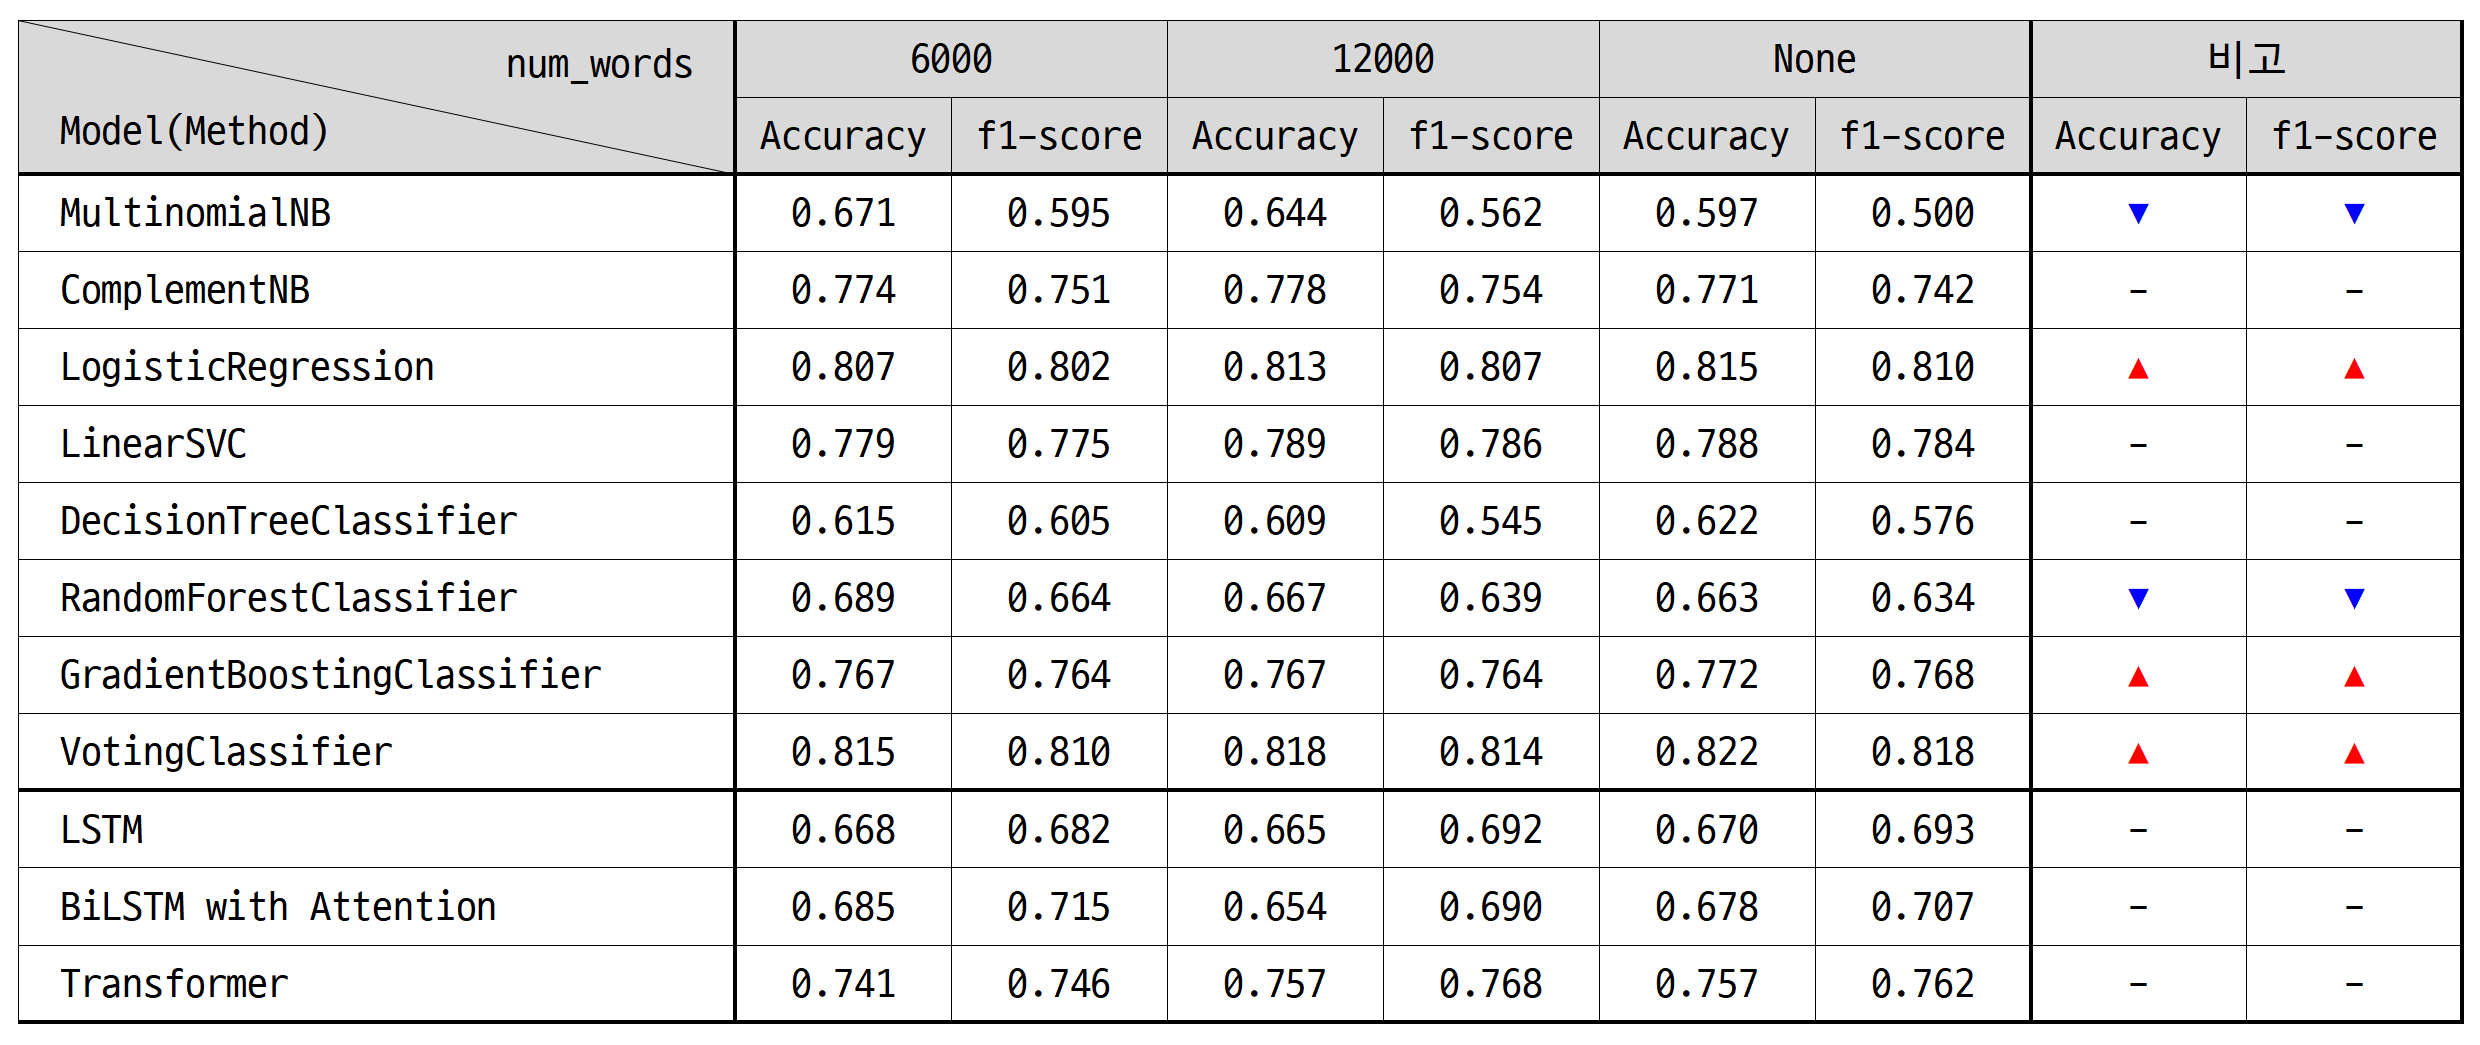

&nbsp;

### 머신러닝 기법 특징과 분석

---

|모델|특징|분석|
|:---|:---|:---|
|MultinomialNB|LogisticRegression이나 LinearSVC 같은<br>선형 분류기보다 훈련 속도가 빠른 편<br>대신 일반화 성능이 조금 떨어진다.|실제로도 훈련 소요시간은 짧았다.<br>LogisticRegression이나 LinearSVC 보다<br>성능이 떨어지는 것을 확인할 수 있다.|
|ComplementNB|(분류) 데이터가 불균형할 경우를 대비하여<br>나이브 베이즈 분류기를 보완한 모델.<br>일반적으로 MultinomialNB 보다 성능이 좋다.|훈련결과 정리에서 MultinomialNB 보다<br>높은 성능을 확인 할 수 있다.|
|LogisticRegression|다중 클래스 분류를 위한 로지스틱 회귀<br>Softmax Regression 라고도 한다.<br>이름은 회귀지만, 실제로는 분류 수행.<br>N개 클래스 일 때, N차원의 벡터가,<br>각 클래스 정답일 확률을 표현하도록 정규화.|오차와 정답간의 차이를 줄여나가는<br>softmax 회귀 과정을 통해 가중치/편향 학습.<br>오랜 훈련시간, 비교적 높은 정확도.|
|LinearSVC|대표적인 선형분류모델.<br>기본적으로는 이진분류만을 지원하나,<br>사이킷런의 이진분류 알고리즘은<br>클래스의 수 만큼 이진 분류모델 만들어 학습|클래스의 수 만큼 만들어진 이진 분류기가<br>가장 높은 점수를 내는 분류기의 클래스를<br>예측값으로 선택.<br>속도, 정확도 모두 평균이상.<br>ComplementNB 정도(혹은 살짝 더 높은) 성능.|
|DecisionTreeClassifier|결정트리는 결정에 다다르기 위해<br>'예/아니오' 질문을 이어 나가면서 학습.<br>고차원이고 희소한 데이터에 대해서는<br>성능이 나오지 않는다.|DTM이나 TF-IDF 행렬의 경우 고차원이며,<br>대부분의 값이 0인 희소한 데이터.<br>트리 계열의 모델이라 선형분류 모델에 비해<br>부족한 성능을 확인 할 수 있다.|
|RandomForestClassifier|결정트리를 사용하는 앙상블 모델.<br>과적합(Overfitting) 문제를 앙상블로 해결.|기존 트리계열의 모델들의 낮은 성능이<br>어느정도 보완된 결과를 확인 할 수 있다.|
|GradientBoostingClassifier|결정트리를 사용하는 앙상블 모델.<br>랜덤포레스트와 차이점은 이전 트리의 오차를<br>보완하는 방식으로 순차적으로 트리를 생성.<br>메모리 적게 사용, 정확도 준수, 예측 빠름.<br>훈련 시간 속도는 느리고 오래 걸림.<br>트리기반 모델 특성상 고차원데이터에 불리.|TF-IDF 행렬은 희소하고 고차원 데이터.<br>LogisticRegression, LinearSVC 보다 낮지만,<br>트리 계열 모델에서는 가장 높은 성능.|
|VotingClassifier|투표를 통해 결과 도출하는 모델.<br>여기서는 소프트 보팅 사용.|일반적인 앙상블기법 장점 – 성능이 좋다.<br>로지스틱 회귀, CNB, 그래디언트부스팅 사용,<br>소프트 보팅결과 가장 높은 정확도 산출.|

&nbsp;

### Vocabulary size 에 따른 분석

<hr>

Vocabulary size를 크게 가져갈 수록 일반적으로는 성능의 향상을 기대할 수 있을 것이라 생각하였다.

실제 훈련/평가 과정에서는 LogisticRegression 과  GradientBoostingClassifier 모델이

Vocabulary size 크기가 증가 할 수록 약간의 성능 증가를 확인 할 수 있었다.

MultinomialNB, RandomForestClassifier 의 경우, 모두 선형모델이 아니다.

이 모델들은, 희소 행렬과, 고차원 데이터에 불리한 모습을 보였는데,

실험을 통해, Vocabulary size 크기가 증가 할 수록 다른 모델들 대비 유독 성능이 떨어지는 것을 확인 할 수 있다.

단어 수를 배로 늘려가며 확인한 결과인데 성능 차이가 크지 않은 이유로 생각해 볼 수 있는 내용은,

아래의 「딥러닝 모델과의 성능 분석」 파트에서도 다루겠지만, 몇가지 추정하는 내용은 아래와 같다.

사용한 데이터 자체가 문법적으로 올바르고, 데이터의 라벨이 불균형하게 분포되어있어서,

특정 카테고리에서 자주 쓰이는 단어들이 높은 비중을 차지할 것이다.

그래서 단어 수가 그렇게 많이 필요하지 않을 것이라고 생각한다.

아마도, 단어 수를 점차 줄여가며 테스트를 해 본다거나 오버샘플링 기법을 활용하면 더 좋았을 것 같다.

성능이 떨어지는 모델들의 경우는, 모델 자체의 특성도 더해졌기 때문이 아닐까 생각한다.

기본적으로 다른 모델들 대비 성능들이 떨어졌던 모델들이다.

사용한 데이터처럼, 불균형한 데이터에 취약한 모델인, MultinomialNB.

RandomForestClassifier는 DecisionTreeClassifier 보다 개선되었다고는 하나, 위 표의 정리에서도 확인 할 수 있듯,

트리 계열은 기본적으로 여기서 사용한 데이터와 같이, 고차원이고 희소한 데이터에 대해서는 성능이 나오지 않는 모델이다.


반면, 기본 성능도 괜찮았던, GradientBoostingClassifier 은 성능이 올라간 것을 확인 할 수 있는데,

GradientBoostingClassifier 모델은 다른 트리 계열 모델 대비 이전 트리의 오차를보완하는 방식이 더해진 모델이다.

LogisticRegression 모델도 오차와 정답간의 차이를 줄여나가는 방법을 사용하는 모델이고.

VotingClassifier 도 이러한 오차를 줄여가는 모델을 사용하여 soft voting 하였다.

이러한 모델들이 단어 수의 증가에 따른 약간이지만 성능 향상을 확인 할 수 있다.

&nbsp;

### 딥러닝 모델과의 성능 분석

---

- 딥러닝 모델의 경우, LSTM → Attention → Transformer 순서로 성능이 좋은 것을 확인할 수 있다. <br>&nbsp;

- Vocabulary size 에 따른 영향은 유의미한 차이를 보여주는 모델은 없는 것으로 보인다. <br>&nbsp;

- 참고자료로 사용한 "고전적인 기계 학습 알고리즘에 대한 비교 연구" 내용에 따르면, 다음과 같다.<br>&nbsp;
  
  + 고전적인 기계 학습 알고리즘이라 함은, 본 프로젝트에서의 머신러닝 모델들을 의미한다.<br>&nbsp;
 
  + 연구 결론에서, ＂문법적으로 올바르다면 고전적인 기계 학습 모델이 꽤 잘 작동한다＂ 라는 결론을 내리고 있다.<br>&nbsp;
  
  + 로이터 뉴스기사 데이터의 경우에, 뉴스기사의 내용이므로, 거의 대부분 문법적으로 문제가 없을 것이다.<br>&nbsp;
  
  + 머신러닝의 정확도 / f1-score 가 높은 이유를 찾을 수 있다. <br>&nbsp;

- 딥러닝을 사용하지 않고 머신 러닝만을 사용하는 상황에서 텍스트를 벡터화하여 좋은 feature 들을 뽑아내기 위해,<br>
DTM, TF-IDF 행렬을 사용하여 벡터화를 수행하였고, 머신러닝을 통해서도 높은 성능의 결과를 확인 할 수 있었다.<br>&nbsp;
  
- 머신러닝과 딥러닝 모델을 비교하였을때, 딥러닝 모델보다 머신러닝이 더 성능이 좋았던 이유를 생각해보면, 다음과 같다.<br>&nbsp;

  + 로이터 뉴스기사 데이터의 경우에, 클래스 3, 4 가 전체 46개 클래스의 데이터에서 절반 가까이를 차지하고 있는<br>
  불균형 데이터(imbalanced data) 라고 볼 수 있다.<br>&nbsp;
  
  + 참고자료 ＂불균형 데이터 (imbalanced data) 처리를 위한 샘플링 기법＂ 에서, 이러한 문제에 대처할 방법으로<br>
  데이터를 조정해서 불균형 데이터를 해결하는 언더샘플링 / 오버샘플링 기법을 제시하고 있다.<br>&nbsp;
  
  + 현재 딥러닝 모델은, 머신러닝 모델들과 공정한 비교를 한다는 이유로, 이러한 전처리 과정들을 적용하지 않은 상태이다. <br>&nbsp;
  
- 더 나은 데이터 전처리 기법 또는 임베딩을 통해 딥러닝 모델 정확도 향상을 위한 개선을 해 보는 것이 필요하다고 생각한다.


<hr>

## ■ 프로젝트 회고

### 1) 이번 프로젝트에서 "어려웠던 점"

학습시간이 오래 걸리는 것들이 많아서 어려웠다.

이런저런 참고 자료 찾고 개념정리하느라 어려웠다.

### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

딥러닝(+임베딩)을 하지 않고, 머신러닝에서 DTM, TF-IDF 를 활용하여 텍스트 벡터화 및 머신러닝으로 분류 수행을 실습했다.

불균형 데이터의 예측 결과를 평가하기에는 Accuracy 메트릭 보다 f1-score 를 사용하는 것이 더 적합한데, 

여기서 f1-score 와 confusion matrix 에 대해서 학습하였다.

다양한 머신러닝 모델들로 훈련을 진행해보고, 그 결과를 평가하고 분석해 보며, 여러 모델들의 특징을 분석하였다.

단어 수에 따른 성능을 비교해 보면서, 영향을 주는 요소들에 대해 생각해 보았다.

### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

자연어 처리 분야에서 머신러닝을 이렇게 까지 끌어올려서 활용한다는 것이 살짝 놀라웠다.

딥러닝을 쓰는게 당연한듯 생각하고 있었는데, 훈련과 평가결과를 보니, 상당히 인상적이었다.

모호한점은, 단어 수에 따른 성능비교 부분인데, 전반적으로 성능이 조금 개선된 모델이 있는가 하면,

저하된 모델도 있고, 영향을 크게 받지 않는 듯한 모델도 있다.

실험에서 왜 굳이 단어 수에 따른 성능비교를 제시했는지, 본 프로젝트에서의 실험 과정에서 잘못된 부분이 있는건지,

혹시 이 프로젝트에서 단어 수의 변경은 어떤 결과를 확인 할 수 있는 수행 목표인데, 내가 그것을 확인 하지 못한것인지…

이도저도 확신이 들지 않는점이, 프로젝트 진행 과정에서 지속적으로 생각했던 가장 모호한 점이다.

### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

딥러닝 모델에서도 동일한 유형의 결과를 산출해서 비교하기 위해 f1-score 적용 구현하는 코드를 참고자료 찾아 추가해주었다.

단어 수에 다른 성능 비교를 위해, 6000, 12000, None 의 3가지 방법으로 비교 하였고,

이에 따라 머신러닝 모델 8 종류, 딥러닝 모델 3 종류를 전부 비교하였다. (모델 11 * 단어 수 3)

머신러닝 알고리즘의 특성에 근거한 원인 분석을 표로 정리하고 요약 시도하였다.

딥러닝 모델 성능과 비교한 결과를 전체 실험 요건에 맞추어 표로 정리하고 요약하였다.

### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

이번 프로젝트는 여러가지 외부 자료에서 얻은 정보가 굉장히 많다.

노드 학습 부분의 내용이 충실하긴 하지만, 루브릭 평가 지표를 달성하기에는

결국 외부 자료를 참고해야할 필요가 있다. (f1-score 및 모델 특징 분석 부분 등)

하지만 루브릭 내용을 이해하고 외부 자료를 참고하면 그렇게 어려운 문제는 아닐 것이라고 생각한다.

### 6) 자기 다짐

실험에 시간을 많이 소모했던 프로젝트여서, 한번 돌리면 결과를 봐야 하는데,

시간이 오래 걸리다보니 자꾸 미루게 되어, 빠르게 진행하지 못했다.

그러다보니 또 프로젝트가 밀리는 듯한 느낌이 들어서 조급해지니 그냥 내려놓고 포기할까 싶은 나태함이 찾아왔다.

인간의 어리석음이란… 완성을 못 할 뻔 했다.

여기서, 사실 이해가 덜 되고, 부족한 부분이 생겨서, 이것도 빨리 공부를 해야 할 거 같은데,

계속 미루고 또 미루고 하고 있다. 반성 한다 해도, 나아지는 모습이 없으니 아무래도 난 이제 글러먹은 것 같다.

이번 프로젝트는 오늘 아침부터 계속 집중해서 시간 투자를 해서, ＂내용은 부족하더라도 마무리는 지어 놓아야지＂

그렇지 않으면 다음 프로젝트나 논문 리뷰같은 일정이 감당 안되서 내려놓을거 같아서…

마감 눈앞에 닥친 웹툰 만화가 마냥 오늘 하루 올인해버렸다.

뭔가 외줄타기 하는 느낌이다. 한번 내려놓았다가 조만간 크게 빵꾸 낼 느낌이다.

주말에 제발 코드 한줄, 책 한페이지 라도 보고 공부를 좀 해야겠다. 하다못해 밀린 프로젝트라도 마무리 하던가.

일정이 계속 밀리고, 할 일은 계속 쌓이고, 하나 마치면 하나 생기고… 정신을 좀 차려야 겠다.

<hr>

## ◎ Reference

 - [Text Analytics – Document Term Matrix](https://www.darrinbishop.com/blog/2017/10/text-analytics-document-term-matrix/)
 
 
 - [코사인 유사도(Cosine Similarity)](https://wikidocs.net/24603)
 
 
 - [TF-IDF에 대하여](http://openuiz.blogspot.com/2018/11/tf-idf.html)
 
 
 - [TF-IDF 문서 유사도 측정](https://www.youtube.com/watch?v=Rd3OnBPDRbM)
 
 
 - [고유값(eigenvalue), 고유벡터(eigenvector), 고유값 분해(eigen decomposition)](https://bkshin.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-19-%ED%96%89%EB%A0%AC?category=1057680)
 
 
 - [잠재 의미 분석(Latent Semantic Analysis, LSA)](https://wikidocs.net/24949)
 
 
 - [특잇값 분해](https://datascienceschool.net/02%20mathematics/03.04%20%ED%8A%B9%EC%9E%87%EA%B0%92%20%EB%B6%84%ED%95%B4.html)
 
 
 - [특이값 분해 ( SVD ) 매트랩 예제 및 쉬운 이해! Singular value decomposition 의 목적](https://www.youtube.com/watch?v=vxJ1MzfvL5w)
 
 
 - [A Stepwise Introduction to Topic Modeling using Latent Semantic Analysis](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/)
 
 
 - [scikit-learn - fit_transform](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD.fit_transform)
 
 
 - [LDA Topic Modeling](https://lettier.com/projects/lda-topic-modeling/)
 
 
 - [Tutorial: Text Mining Using LDA and Network Analysis](https://noduslabs.com/cases/tutorial-lda-text-mining-network-analysis/)
 
 
 - [잠재 디리클레 할당(Latent Dirichlet Allocation, LDA)](https://wikidocs.net/30708)
 
 
 - [텍스트 데이터 분석 [토픽 모델] - (4) LDA 모형](https://serviceapi.nmv.naver.com/flash/convertIframeTag.nhn?vid=A008B9E1EAFC02C99F92928155487839090E&outKey=V1210ad4156cf64ce0c6a3e18cecaae499f6528784c999ca6541c3e18cecaae499f65&width=544&height=306)
 
 
 - [문서 단어 행렬(Document-Term Matrix, DTM)](https://wikidocs.net/24559)
 
 
 - [TF-IDF(Term Frequency-Inverse Document Frequency)](https://wikidocs.net/31698)
 
 
 - [나이브 베이즈(Naive Bayes) 분류 (2/2) - 베이즈 정리 (Bayes' Theorem) 쉽게 이해하기](https://www.youtube.com/watch?v=3JWLIV3NaoQ)
 
 
 - [분류성능평가지표 - Precision(정밀도), Recall(재현율) and Accuracy(정확도)](https://sumniya.tistory.com/26)
 
 
 - [Confusion Matrix (혼동행렬) 알고리즘 및 파이썬 실습](https://youtu.be/M0GBAzFV9_A)
 
 
 - [Confusion Matrix 혼동 행렬](https://mjdeeplearning.tistory.com/31)
 
 
 - [의사결정트리 (Decision Tree) 알고리즘 쉽게 이해하기](https://www.youtube.com/watch?v=n0p0120Gxqk)
 
 
 - [랜덤포레스트](https://www.youtube.com/watch?v=nZB37IBCiSA)
 
 
 - [앙상블 - 하드보팅, 소프트보팅](https://youtu.be/y4Wh0E1d4oE)
 
 
 - [Classification - metrics (f1-score)](https://hongl.tistory.com/136)
 
 
 - [How to get accuracy, F1, precision and recall, for a keras model?](https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)


 - [Classification & Clustering 모델 평가](https://bcho.tistory.com/1206)
 
 
 - [Comparative Study on Classic Machine learning Algorithms](https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222)
 
 
 - [OvA vs OvO](https://djy-git.github.io/2019/07/13/ovaovr.html#gsc.tab=0)
 
 
 - [One-versus-the-rest(OvR) ,One-versus-One(OvO)](https://seong6496.tistory.com/213)
 
 
 - [Applied Machine Learning: Naive Bayes, Linear SVM, Logistic Regression, and Random Forest](https://www.linkedin.com/pulse/applied-machine-learning-naive-bayes-linear-svm-logistic-thota)


 - [BiLSTM with Attention mechanism](https://wikidocs.net/48920)


 - [Text classification with Transformer](https://keras.io/examples/nlp/text_classification_with_transformer/)
 
 
 - [텐서 플로우 블로그 (Tensor ≈ Blog) - 2.3.4 나이브 베이즈 분류기](https://tensorflow.blog/%ed%8c%8c%ec%9d%b4%ec%8d%ac-%eb%a8%b8%ec%8b%a0%eb%9f%ac%eb%8b%9d/2-3-4-%eb%82%98%ec%9d%b4%eb%b8%8c-%eb%b2%a0%ec%9d%b4%ec%a6%88-%eb%b6%84%eb%a5%98%ea%b8%b0/)
 
 
 - [불균형 데이터 (imbalanced data) 처리를 위한 샘플링 기법](https://casa-de-feel.tistory.com/15)

&nbsp;